In [328]:
import numpy as np
import matplotlib.pyplot as plt
# to save and write as pngs
from imageio import imwrite, imread
import scipy.ndimage
import scipy.sparse.csgraph
import math
import SimpleITK as sitk
import sklearn.cluster
import sklearn.preprocessing

[[0.         0.         0.         ... 0.         0.         0.56307565]
 [0.         0.         0.         ... 0.         0.         0.56307565]
 [0.         0.         0.         ... 0.         0.         0.56307565]
 ...
 [0.         0.         0.         ... 0.         0.         0.56307565]
 [0.         0.         0.         ... 0.         0.15016267 0.64803189]
 [0.56307565 0.56307565 0.56307565 ... 0.56307565 0.64968153 0.75076754]]


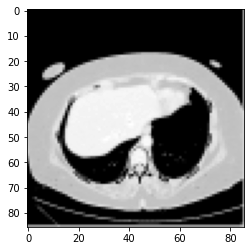

In [575]:
# get image
image_dcm = sitk.ReadImage('data/IMG-0002-00074.dcm');
image_array_view = sitk.GetArrayViewFromImage(image_dcm)
image = image_array_view.squeeze()
image = np.array(image)

# clip values to range -160 <-> 240, which is the intensity values of blood-filled organs.
image[image < -160] = -1024
image[image > 240] = -1024

# scale down image
#scaling_factor = 32
#image = scipy.ndimage.affine_transform(image, matrix=[[scaling_factor, 0], [0, scaling_factor]], offset=0, output_shape=(int(image.shape[0]/scaling_factor), int(image.shape[1]/scaling_factor)))
from skimage.measure import block_reduce
scaling_factor = 6;

image = block_reduce(image, block_size=(scaling_factor, scaling_factor), func=np.mean)

image = np.sqrt((image+np.abs(np.min(image)))**2) # add an offset and 'remove' negative values
#print(image)
#image += 1024
#print(np.max(image))
image = image/np.max(image) # normalize
#image = image/2048

print(image)

# plot image
plt.imshow(image, cmap='gray')

In [577]:
# similarity matrix - nodes are connected if they are neighbours and they share the same value
num_pixels = image.size
print(num_pixels, image.shape)

similarity_matrix = np.zeros((num_pixels,num_pixels),dtype=float)
print(similarity_matrix.shape)

num_edges = num_pixels**2
meaningful_segment = int(0.1 * num_edges) # used for printing progress

image_width = image.shape[0]

max_distance = 10

sigma_distance = int(0.1 * image_width) # 10-20% of feature distance
sigma_intensity = 0.1 # 10-20% of feature distance (0 <-> 1)

for i in range(0,image_width):
    for j in range(0,image_width):
        sm_i = j + i * image_width
        if sm_i % meaningful_segment == 0:
            print("{:.2f}%".format(int((sm_i/num_edges)*100)))
        for ii in range(0,image_width):
            for jj in range(0,image_width):

                #distance = np.linalg.norm(np.array([i,j]) - np.array([ii,jj]))
                sm_j = jj + ii * image_width
                if similarity_matrix[sm_i,sm_j] != 0:
                    continue

                #if distance <= max_distance: #  and image[i,j] != 0 and image[ii,jj] != 0
                intensity_diff = np.linalg.norm(np.array(image[i,j]) - np.array(image[ii,jj]))
                weight = np.exp(-np.power(intensity_diff,2)/sigma_intensity)
                # * np.exp(-np.power(distance,2)/sigma_distance)
                #print(distance, (i,j), (ii,jj), intensity_diff, weight)
                #if weight >= 0.6:
                similarity_matrix[sm_i,sm_j] = weight
                similarity_matrix[sm_j,sm_i] = weight # matrix is symmetric

7396 (86, 86)
(7396, 7396)
0.00%


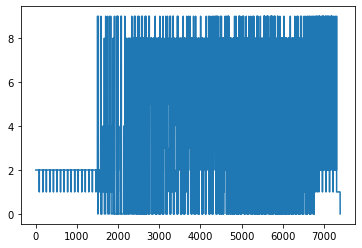

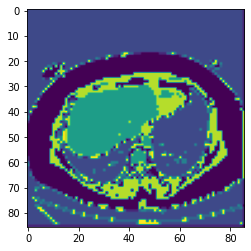

(86, 86) 7396
(7396, 7396)


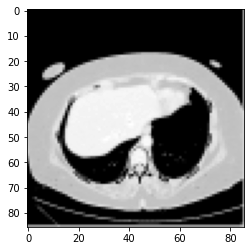

In [578]:
sc = sklearn.cluster.SpectralClustering(n_clusters=10, random_state=0, affinity="precomputed")
sc.fit(similarity_matrix)
arr = sc.labels_
plt.plot(arr)
plt.show()
newimg = arr.reshape(image_width, image_width)
plt.imshow(newimg)
plt.show()
plt.imshow(image, cmap='gray')

print(image.shape, len(sc.labels_))
print(similarity_matrix.shape)

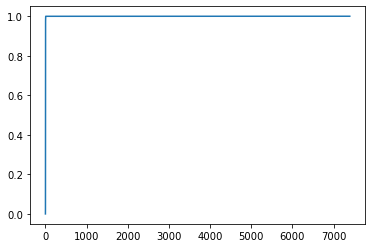

In [579]:
# clustering following: https://changyaochen.github.io/spectral-clustering/
graph_laplacian = scipy.sparse.csgraph.laplacian(similarity_matrix,normed=True)

# get eigenvalues + vectors
eigenvalues, eigenvectors = np.linalg.eigh(graph_laplacian)

ind = np.argsort(eigenvalues, axis=0)

eigenvalues = eigenvalues[ind]
eigenvectors = eigenvectors[:,ind]

plt.plot(eigenvalues)

(7396, 7396)
(7396, 10)


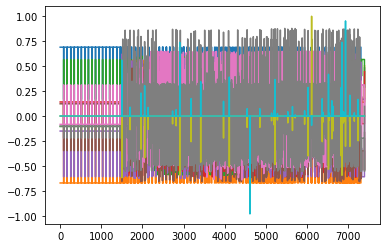

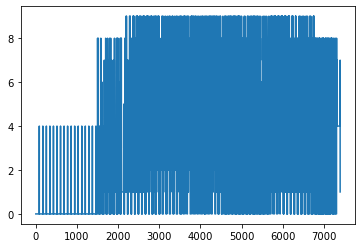

In [580]:
n_clusters = 10

print(eigenvectors.shape)
selected_eigenvectors = eigenvectors[:,:n_clusters]

selected_eigenvectors = sklearn.preprocessing.normalize(selected_eigenvectors, norm='l2', axis=1)

# k-means
clusters = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(selected_eigenvectors)

print(selected_eigenvectors.shape)
plt.plot(selected_eigenvectors)
plt.show()
plt.plot(clusters.labels_)

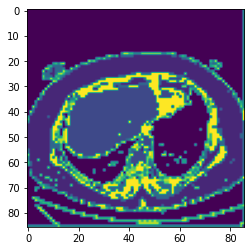

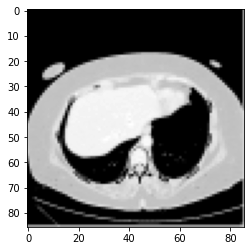

In [581]:
# cluster => image

#colors = [-1024,-900,-720,-500,-250,0,250,500,720,900,1024]

cluster_image = np.zeros(image.shape)

for i, l in enumerate(clusters.labels_):
    x = i % image_width
    y = int(i / image_width)
    cluster_image[y,x] = l

# plot image
plt.imshow(cluster_image)
plt.show()
plt.imshow(image, cmap="gray")